## Iteration 8_1

Here we try to improve the performance by trying different models and comparing to see if other models can sqeeze more performance out

### DenseNet169 model:

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf


class CustomModel(tf.keras.Model):
    def __init__(self, number_of_samples):
        super(CustomModel, self).__init__()
        
        # Load and configure the base model
        base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
        
        for layer in base_model.layers:
            layer.trainable = False
        
        # Add custom layers for classification
        x = base_model.output
        x = BatchNormalization()(x)
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.42)(x)
        x = Dense(128, activation='relu')(x)
        x = Dropout(0.42)(x)
        preds = Dense(7, activation='softmax')(x)

        # Define the complete model
        self.model = Model(inputs=base_model.input, outputs=preds)

        # Set cyclical learning rate parameters
        self.lower_bound = 1e-4
        self.upper_bound = 1e-3
        self.half_cycle_multiple = 4
        self.batch_size = 32
        self.steps_per_epoch = int(number_of_samples / self.batch_size)
        self.half_cycle_length = self.steps_per_epoch * self.half_cycle_multiple
        self.full_cycle_length = 2 * self.half_cycle_length
        self.learning_rates = []
        self.class_weight = None
        self.norms = []
        self.epochs = 5

    def compile(self):
        # Compile the internal model
        self.model.compile(optimizer=SGD(learning_rate=self.lower_bound, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)
    
    def predict(self, data):
        return self.model.predict(data)
    


    def fit_epochs(self, train_generator, validation_generator, epochs, checkpoint_path, lr=None, class_weight=None):

        self.epochs = epochs

        if lr is not None:
            self.lower_bound = lr[0]
            self.upper_bound = lr[1]
        
        if class_weight is not None:
            self.class_weight = class_weight

        class GradientLogger(Callback):
            def __init__(self, model):
                super().__init__()
                self.model = model
                self.gradient_norms_log = []
                self.norms = []

            def on_epoch_end(self, epoch, logs=None):
                with tf.GradientTape() as tape:
                    norm = tf.sqrt(sum([tf.reduce_sum(tf.square(var)) for var in self.model.trainable_variables]))
                    self.norms.append(norm.numpy())

            def get_norms(self):
                return self.norms

        gradient_logger = GradientLogger(self.model)

        

        checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=False,
            mode='min',
            verbose=1
        )

        early_stopping_callback = EarlyStopping(
            monitor='val_loss',  
            patience=40,          
            min_delta=0.001,
            start_from_epoch=5
        )

        # Train the model using the cyclical learning rate scheduler and checkpoint callback
        history = self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            verbose=1,
            class_weight=self.class_weight,
            callbacks=[self.lr_scheduler, checkpoint_callback, early_stopping_callback, gradient_logger]
        )

        self.norms = gradient_logger.get_norms()

        return history
    
    def plot_trainable_weights(self):
        plt.figure(figsize=(8, 6))
        plt.plot(range(1, self.epochs + 1), self.norms, marker='o', label='Norm of Trainable Variables')
        plt.xlabel('Epoch')
        plt.ylabel('Norm')
        plt.title('Norm of Trainable Variables vs Epoch')
        plt.grid()
        plt.legend()
        plt.show()
    
    def evaluate(self, data):
        # Evaluate the model on the validation set
        return self.model.evaluate(data)

    def unfreeze(self, number_of_layers_to_unfreeze=None):
        # Unfreeze all layers in the base model
        if number_of_layers_to_unfreeze is None:
            for layer in self.model.layers:
                layer.trainable = True
            print("All layers have been unfrozen.")
        else:
            # Ensure number_of_layers_to_unfreeze is valid
            if number_of_layers_to_unfreeze > len(self.model.layers):
                print(f"Warning: Only {len(self.model.layers)} layers exist. Unfreezing all layers.")
                number_of_layers_to_unfreeze = len(self.model.layers)

            for layer in self.model.layers[-number_of_layers_to_unfreeze:]:
                layer.trainable = True

            print(f"Last {number_of_layers_to_unfreeze} layers have been unfrozen.")


    def lr_find(self, train_generator, validation_generator, min_lr=1e-10, max_lr=0.01, epochs=10, changes_weights=True):

        weights = self.model.get_weights()
        steps_per_epoch = train_generator.samples / self.batch_size
        total_batches = steps_per_epoch * epochs
        
        # Custom callback for linear learning rate increase
        class LinearLRScheduler(Callback):
            def __init__(self, min_lr, max_lr, total_batches):
                super().__init__()
                self.min_lr = min_lr
                self.max_lr = max_lr
                self.total_batches = total_batches
                self.batch_count = 0
                self.lr_history = []
                self.loss_history = []

            def on_batch_end(self, batch, logs=None):
                # Log the loss and learning rate
                loss = logs.get('loss')
                self.loss_history.append(loss)
                
                # Incrementally increase learning rate
                self.batch_count += 1
                lr = self.min_lr + (self.max_lr - self.min_lr) * (self.batch_count / self.total_batches)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.lr_history.append(lr)

        # Instantiate the linear learning rate scheduler callback
        lr_scheduler_callback = LinearLRScheduler(min_lr, max_lr, total_batches)
        
        # Compile the model with the minimum learning rate
        self.model.compile(optimizer=SGD(learning_rate=min_lr), loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Train the model with the learning rate scheduler to find optimal lr
        self.model.fit(
            train_generator,
            validation_data=validation_generator,
            epochs=epochs,
            batch_size=self.batch_size,
            class_weight=self.class_weight,
            callbacks=[lr_scheduler_callback],
            verbose=1
        )

        if not changes_weights:
            self.model.set_weights(weights)

        # Plot learning rate vs. loss
        plt.plot(lr_scheduler_callback.lr_history, lr_scheduler_callback.loss_history)
        plt.xscale('log')
        plt.xlabel('Learning Rate')
        plt.ylabel('Loss')
        plt.title('Loss vs. Learning Rate')
        plt.show()

    @property
    def lr_scheduler(self):
        # Custom cyclical learning rate scheduler
        class BatchLearningRateScheduler(tf.keras.callbacks.Callback):
            def __init__(self, lower_bound, upper_bound, full_cycle_length, learning_rates):
                super().__init__()
                self.lower_bound = lower_bound
                self.upper_bound = upper_bound
                self.full_cycle_length = full_cycle_length
                self.batch_count = 0
                self.learning_rates = learning_rates

            def on_batch_end(self, batch, logs=None):
                cycle_position = np.abs((self.batch_count % self.full_cycle_length) / self.full_cycle_length - 0.5) * 2
                lr = self.lower_bound + (self.upper_bound - self.lower_bound) * (1 - cycle_position)
                tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                self.learning_rates.append(lr)
                self.batch_count += 1

        return BatchLearningRateScheduler(self.lower_bound, self.upper_bound, self.full_cycle_length, self.learning_rates)

    


# Example usage:
# model = CustomModel(number_of_samples=1000)
# model.compile()
# model.fit_epochs(epochs=10, lr=0.001)
# model.unfreeze()
# lr_history = model.lr_find()


### Training:

In [8]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_8_1"
model_dir = f'../../models/best_model_{iteration}.h5'

In [9]:
from keras.applications.densenet import preprocess_input
import sys
import os
sys.path.append(os.path.abspath("../.."))


# Now import HomemadeDataloader from homemade_dataloader.py
from homemade_dataloader import DataloaderFactory


batch_size=32
dist = [3008,3008,3008,3008,3008,3008,3008]
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

Found 8202 images belonging to 7 classes (dist says 21056)
Found 1758 images belonging to 7 classes (dist says 0)
Found 1758 images belonging to 7 classes (dist says 0)


In [10]:

model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

51877672/51877672 [==============================] - 2s 0us/step


In [ ]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=5, checkpoint_path=model_dir)
histories.append(history1)

Epoch 1/5
658/658 [==============================] - ETA: 0s - loss: 2.0146 - accuracy: 0.2088
Epoch 1: val_loss improved from inf to 16.31582, saving model to ../../models/best_model_iteration_8_1.h5


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


658/658 [==============================] - 935s 1s/step - loss: 2.0146 - accuracy: 0.2088 - val_loss: 16.3158 - val_accuracy: 0.0237
Epoch 2/5
658/658 [==============================] - ETA: 0s - loss: 1.6346 - accuracy: 0.3702
Epoch 2: val_loss did not improve from 16.31582
658/658 [==============================] - 868s 1s/step - loss: 1.6346 - accuracy: 0.3702 - val_loss: 20.8507 - val_accuracy: 0.0226
Epoch 3/5
 81/658 [==>...........................] - ETA: 12:51 - loss: 1.5012 - accuracy: 0.4282

All layers have been unfrozen.
Epoch 1/5
658/658 [==============================] - 242s 365ms/step - loss: 2.0335 - accuracy: 0.2189 - val_loss: 1.6244 - val_accuracy: 0.5237
Training set
Epoch 2/5
658/658 [==============================] - 219s 331ms/step - loss: 1.6379 - accuracy: 0.3615 - val_loss: 1.0690 - val_accuracy: 0.6817
Training set
Epoch 3/5
658/658 [==============================] - 225s 341ms/step - loss: 1.3147 - accuracy: 0.4967 - val_loss: 0.8247 - val_accuracy: 0.7095
Training set
Epoch 4/5
658/658 [==============================] - 224s 340ms/step - loss: 1.1040 - accuracy: 0.5853 - val_loss: 0.7665 - val_accuracy: 0.7164
Training set
Epoch 5/5
658/658 [==============================] - 223s 339ms/step - loss: 0.9474 - accuracy: 0.6453 - val_loss: 0.8142 - val_accuracy: 0.6800
Training set


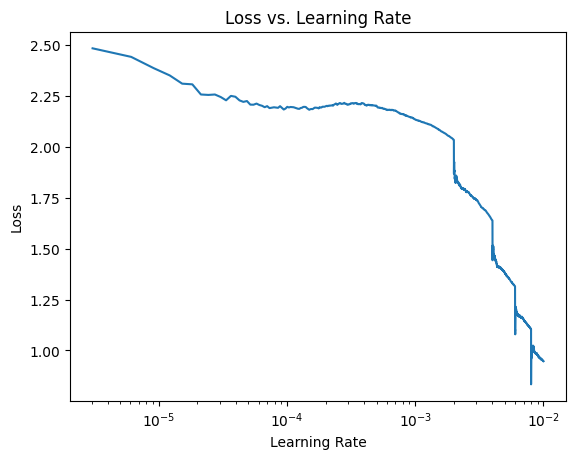

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator, epochs=5)

In [ ]:
history2 = model.fit_epochs(train_generator, validation_generator, epochs=40, checkpoint_path=model_dir, lr=[1e-3, 3e-2])
histories.append(history2)

Epoch 1/40
658/658 [==============================] - ETA: 0s - loss: 0.8684 - accuracy: 0.6759
Epoch 1: val_loss improved from inf to 0.70998, saving model to ../../models/best_model_iteration_7.h5
658/658 [==============================] - 229s 348ms/step - loss: 0.8684 - accuracy: 0.6759 - val_loss: 0.7100 - val_accuracy: 0.7182
Training set
Epoch 2/40


/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


658/658 [==============================] - ETA: 0s - loss: 0.8239 - accuracy: 0.6967
Epoch 2: val_loss did not improve from 0.70998
658/658 [==============================] - 226s 343ms/step - loss: 0.8239 - accuracy: 0.6967 - val_loss: 0.8555 - val_accuracy: 0.6395
Training set
Epoch 3/40
658/658 [==============================] - ETA: 0s - loss: 0.7675 - accuracy: 0.7195
Epoch 3: val_loss did not improve from 0.70998
658/658 [==============================] - 249s 378ms/step - loss: 0.7675 - accuracy: 0.7195 - val_loss: 0.7883 - val_accuracy: 0.6719
Training set
Epoch 4/40
658/658 [==============================] - ETA: 0s - loss: 0.7035 - accuracy: 0.7415
Epoch 4: val_loss improved from 0.70998 to 0.68504, saving model to ../../models/best_model_iteration_7.h5
658/658 [==============================] - 237s 361ms/step - loss: 0.7035 - accuracy: 0.7415 - val_loss: 0.6850 - val_accuracy: 0.7234
Training set
Epoch 5/40
658/658 [==============================] - ETA: 0s - loss: 0.6381 -

['class_0', 'class_1', 'class_2', 'class_3', 'class_4', 'class_5', 'class_6']
Balanced Accuracy: 0.6815806433688968
Accuracy on test set: 0.7662037014961243
F1 Score: 0.780834605426539


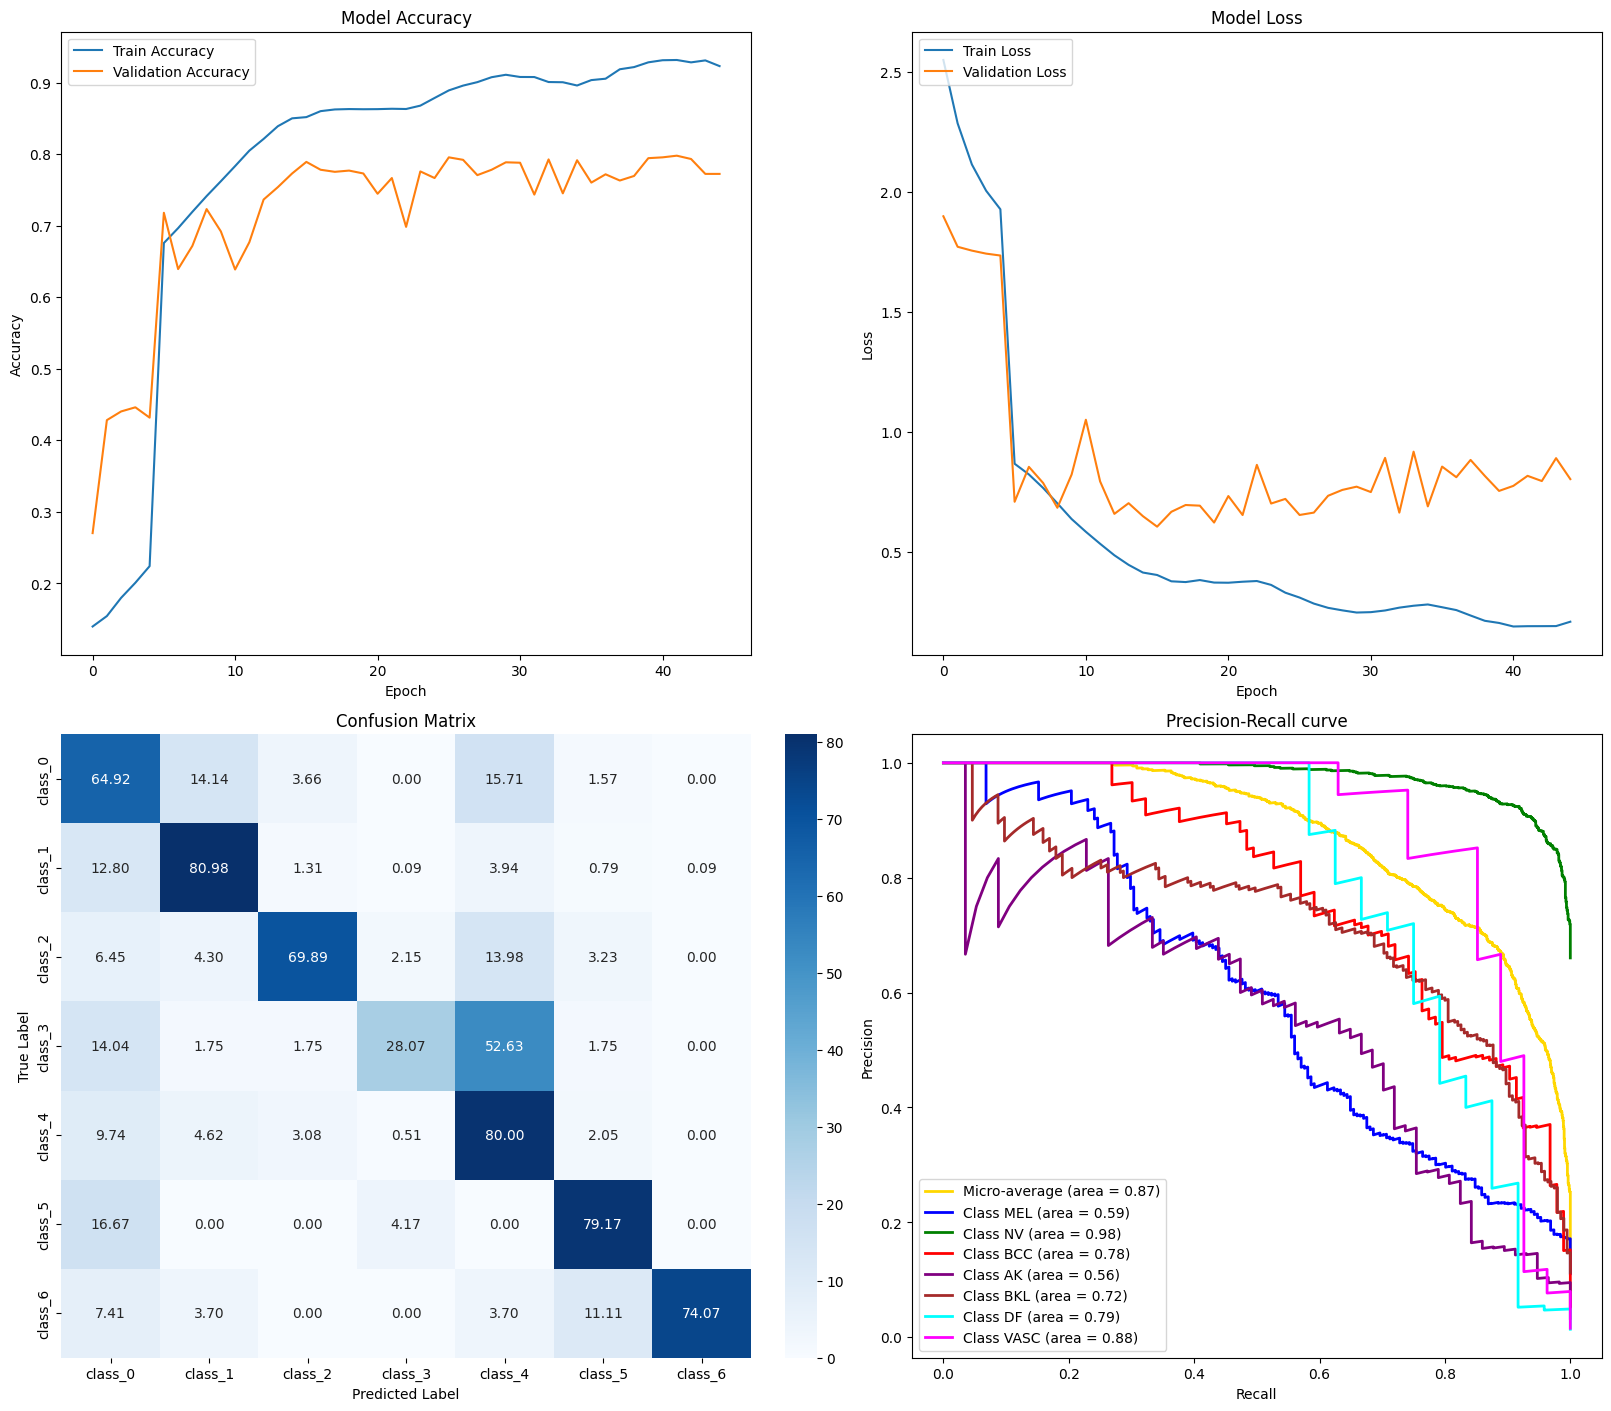

In [ ]:
from tensorflow.keras.models import load_model
from plot_utils import show_all_plots

m = load_model(model_dir)
show_all_plots(histories, m, test_generator)

## Iteration 8_2

### dataloader

In [ ]:
import os
import random
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import Sequence, to_categorical
from itertools import chain

class Dataloader(Sequence):
    def __init__(self, data, batch_size, image_size, is_validation=False, preprocess_function=None, class_distribuition=[], class_names=[]):
        #self.data_dir = data_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.isValidation = is_validation
        self.class_distribution = class_distribuition if not is_validation else []
        self.preprocess_function = preprocess_function

        self.datagen = ImageDataGenerator(
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=50, 
            height_shift_range=0.2,
            width_shift_range=0.2,
            rotation_range=360, 
            brightness_range=[0.3, 1.8], 
            channel_shift_range= random.uniform(20, 50),
            zoom_range=0.3)

        self.class_names = class_names
        self.num_classes = len(self.class_names)
        self.class_to_label = {class_name: i for i, class_name in enumerate(self.class_names)} # mapping {'class1': 0, 'class2': 1, ...})

        self.image_paths, self.labels = zip(*data)
        self.image_paths = list(self.image_paths)  # Convert from tuple to list
        self.labels = list(self.labels)           # Convert from tuple to list

        self.indexes_for_class = [[] for _ in range(self.num_classes)]

        self.all_image_indices = self._create_indices_distr() if not self.isValidation else list(range(len(self.image_paths)))
        self.samples = len(self.all_image_indices)
        #self._shuffle_indices()
        print(f"Found {len(self.image_paths)} images belonging to {self.num_classes} classes (dist says {sum(self.class_distribution)})")
        self._shuffle_indices()


    def _create_indices_distr(self):
        for index, label in enumerate(self.labels):
            self.indexes_for_class[label].append(index) # I assume its list 4 has all the indexes for label class_5

        res = list(chain.from_iterable(self.indexes_for_class)) # flattens the list-of-lists to one list
        return res



    def _load_data(self):
        image_paths = []
        labels = []
        for class_name in self.class_names:
            class_dir = os.path.join(self.data_dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                image_paths.append(image_path)
                labels.append(self.class_to_label[class_name])

        #print(f"Found {len(image_paths)} images belonging to {self.num_classes} classes (dist says {sum(self.class_distribution)})")
        return image_paths, labels

    def _preprocess_image(self, image_path):
        img = load_img(image_path, target_size=self.image_size)
        x = img_to_array(img)

        if not self.isValidation:
            x = x.reshape((1,) + x.shape)
            x = next(self.datagen.flow(x, batch_size=1))[0]

        if self.preprocess_function:
            x = self.preprocess_function(x)
        return x

    def _shuffle_indices(self):
        random.shuffle(self.all_image_indices)


    def __len__(self):
        num_samples = len(self.all_image_indices) # no_images=100 batchsize=20, then 100/20=5 number of iterations to get through the whole dataset
        return num_samples // self.batch_size
    
    def __getitem__(self, index):
        start = index * self.batch_size
        end = start + self.batch_size
        images = []
        labels = []

        batch_image_indices = self.all_image_indices[start:end]

        for image_index in batch_image_indices:
            image_path = self.image_paths[image_index]
            image = self._preprocess_image(image_path)
            images.append(image)
            labels.append(to_categorical(self.labels[image_index], num_classes=self.num_classes))

        return np.array(images), np.array(labels)

    def on_epoch_end(self):
        if not self.isValidation:
            self._shuffle_indices()




class DataloaderFactory():
    def __init__(self, dir, image_size, batch_size, set_distribution, class_distribution=[], preprocess_function=None):
        self.dir = dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.set_distribution = set_distribution
        self.class_distribution = class_distribution
        self.preprocess_function = preprocess_function
        self.class_names = []

    def _load_data(self):
        """Load images and labels as tuples (path, label)."""
        data = []
        self.class_names = sorted(os.listdir(self.dir))
        for label, class_name in enumerate(self.class_names):
            class_dir = os.path.join(self.dir, class_name)
            for image_name in os.listdir(class_dir):
                image_path = os.path.join(class_dir, image_name)
                data.append((image_path, label))  # Append (path, label) as a tuple
        return data

    def _split_data(self, data):
        """Split data into train, validation, and test sets based on the specified distribution."""
        indices = list(range(len(data)))
        _, val_ratio, test_ratio = [p / 100 for p in self.set_distribution]

        labels = [label for _, label in data]
        train_idxs, test_idxs, _, _ = train_test_split(
            indices, labels, test_size=(val_ratio + test_ratio), stratify=labels
        )
        val_split = val_ratio / (val_ratio + test_ratio)
        val_idxs, test_idxs = train_test_split(
            test_idxs, test_size=(1 - val_split), stratify=[labels[i] for i in test_idxs]
        )

        return {"train": train_idxs, "val": val_idxs, "test": test_idxs}

    def get_dataloaders(self):
        """Generate dataloaders for training, validation, and testing."""
        data = self._load_data()  # List of (path, label) tuples
        data_splits = self._split_data(data)  # Split data by indices
        loaders = {}

        for split, indexes in data_splits.items():
            preprocess_func = self.preprocess_function if split == "train" else None
            split_data = [data[i] for i in indexes]  # Subset the data using indices
            loaders[split] = Dataloader(
                data=split_data,  # Pass the list of tuples
                batch_size=self.batch_size,
                image_size=self.image_size,
                is_validation=(split != "train"),
                preprocess_function=preprocess_func,
                class_distribuition=self.class_distribution,
                class_names=self.class_names
            )

        return loaders["train"], loaders["val"], loaders["test"]

/Users/sebastiangodske/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### Code

In [ ]:
data_dir = "../../Merge Set Ordered"
iteration = "iteration_8_2"
model_dir = f'../../models/best_model_{iteration}.h5'


In [ ]:

from keras.applications.mobilenet_v3 import preprocess_input

import os 
import sys

sys.path.append(os.path.abspath("../.."))


batch_size=32
dist = []
print(sum(dist))
histories = []

factory = DataloaderFactory(data_dir, batch_size=batch_size, image_size=(224,224), set_distribution=(70,15,15), class_distribution=dist, preprocess_function=preprocess_input)

train_generator, validation_generator, test_generator = factory.get_dataloaders()

In [ ]:

from custom_model import CustomModel
model = CustomModel(number_of_samples=train_generator.samples)
model.compile()

In [ ]:
image_counts = {}
total_count = 0

train_dir = "../../Data Set Ordered/training data/"

# Loop over each subdirectory in the main directory
for subdir in os.listdir(train_dir):
    subdir_path = os.path.join(train_dir, subdir)
    
    # Check if it's a directory
    if os.path.isdir(subdir_path):
        # Count files in the subdirectory (assuming all files are images)
        num_images = len([f for f in os.listdir(subdir_path) if os.path.isfile(os.path.join(subdir_path, f))])
        
        # Store the count in the dictionary
        image_counts[subdir] = num_images
        total_count += num_images


#weights = {0: 1.2, 1:0.8,2:1.0, 3:1.2, 4:1.1,5:1.3,6:1.0} 
weights = {}

for subdir, count in image_counts.items():
    weight = total_count / (7 * count)
    weights.update({int(subdir.split("_")[1]): weight})

print(weights)

{4: 1.301832835044846, 3: 4.375273044997815, 2: 2.78349082823791, 5: 12.440993788819876, 0: 1.2854575792581184, 6: 10.075452716297788, 1: 0.21338020666879728}


In [ ]:
history1 = model.fit_epochs(train_generator, validation_generator, epochs=5, class_weight=weights, checkpoint_path=model_dir)
histories.append(history1)

In [ ]:
model.unfreeze()
model.lr_find(train_generator, validation_generator)

In [ ]:
history2 = model.fit_epochs(train_generator, validation_generator, epochs=50, checkpoint_path=model_dir, lr=[1e-4, 1e-3])
histories.append(history2)

In [ ]:

from tensorflow.keras.models import load_model

from plot_utils import show_all_plots

m = load_model(model_dir)
show_all_plots(histories, m, test_generator)